# Pregunta 4

El objetivo de esta pregunta es predecir la posición dentro de un plano de un dispositivo a partir de una serie de señales emitidas por dispositivos Bluetooth. Este problema es una instancia del problema de triangulación de posición, clásico de la literatura.

En este caso en particular, se tratará un problema simplificado en donde se quiere predecir cuadrantes en lugar de puntos específicos. Se dispone de un plano dividido en 24 cuadrantes.

# Obtención y análisis del conjunto de datos

Antes de proponer un esquema de red neuronal, es necesario transformar los datos disponibles a datos entrenables dentro de la red.

En primer lugar, se tiene que cada dato tiene la información de su posición $X$ y $Y$ en el plano cartesiano. Es necesario convertir esta información al cuadrante en el que se encuentra el dispositivo, y luego convertir esta información a dato categórico para poder realizar la predicción.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Load file
df = pd.read_csv("./IndoorFingerprint.csv")


# Describe dataset
df.info()
df.describe()

# Partition the dataset into train and test instances
mask_test = np.loadtxt('mask_test.csv', dtype="i")
inverse_mask = [] 
for index in range(0, len(df)):
    if (not index in mask_test):
        inverse_mask.append(index)


df_train = shuffle(df.drop(index=mask_test), random_state=42)
df_test = shuffle(df.drop(index=inverse_mask), random_state=42)

# Scale the attributes, except for the outputs
y_train = df_train.loc[:, ["X", "Y"]]
df_train.pop("X")
df_train.pop("Y")
scaler = StandardScaler().fit(df_train)
x_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)

y_test = df_test.loc[:, ["X", "Y"]]
df_test.pop("X")
df_test.pop("Y")
scaler = StandardScaler().fit(df_test)
x_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

# Convert point information into quadrants


def position_to_quadrant(x, y):
    quadrant = ( (x // 8) + 1 ) + 6*((y - 5) // 4 )
    return int(quadrant) - 1

y_train = list(map(lambda elem: position_to_quadrant(elem[0], elem[1]), y_train.values))
y_test = list(map(lambda elem: position_to_quadrant(elem[0], elem[1]), y_test.values))

# Convert quadrant index into categorical
y_train = keras.utils.to_categorical(y_train, num_classes=24)
y_test = keras.utils.to_categorical(y_test, num_classes=24)








Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 10 columns):
X       6600 non-null float64
Y       6600 non-null float64
C1hA    6600 non-null int64
0kxZ    6600 non-null int64
tvMX    6600 non-null int64
OlYb    6600 non-null int64
7rk5    6600 non-null int64
F39L    6600 non-null int64
VNSF    6600 non-null int64
tkxI    6600 non-null int64
dtypes: float64(2), int64(8)
memory usage: 515.7 KB


##### Definición de cuadrante

Los cuadrantes se definen desde izquierda a derecha, y desde abajo hasta arriba.

Un punto entre $0 \leq 8$ y $5 \leq 9$ estará en el cuadrante $1$, mientras que una posición igual a $(41, 18)$ estará en el cuadrante 24.

A continuación se presenta el plano para visualizar los cuadrantes

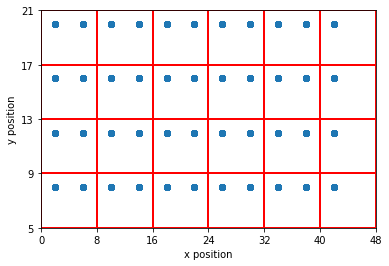

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

##### Boxplot

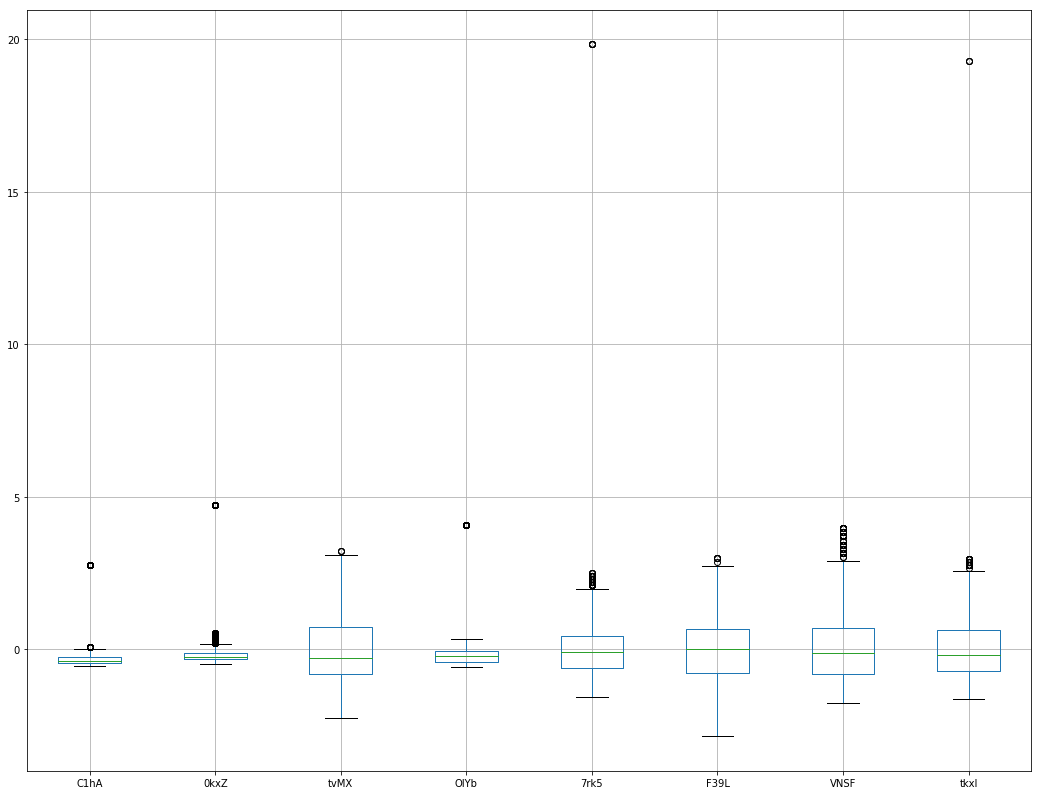

In [3]:
import matplotlib.pyplot as plt
x_train.boxplot(figsize=(18, 14))
plt.show()

Se puede observar en el boxplot la presencia de outliers en los atributos de **7rk5** y **tkxl**. Es muy tentador pensar en la posibilidad de eliminar dichos outliers para evitar el overfitting de la red. Sin embargo y considerando la cantidad de datos de entrenamientos existentes, estos outliers no afectarán las conclusiones que genere la red neuronal de forma relevante

##### Distribución de los atributos

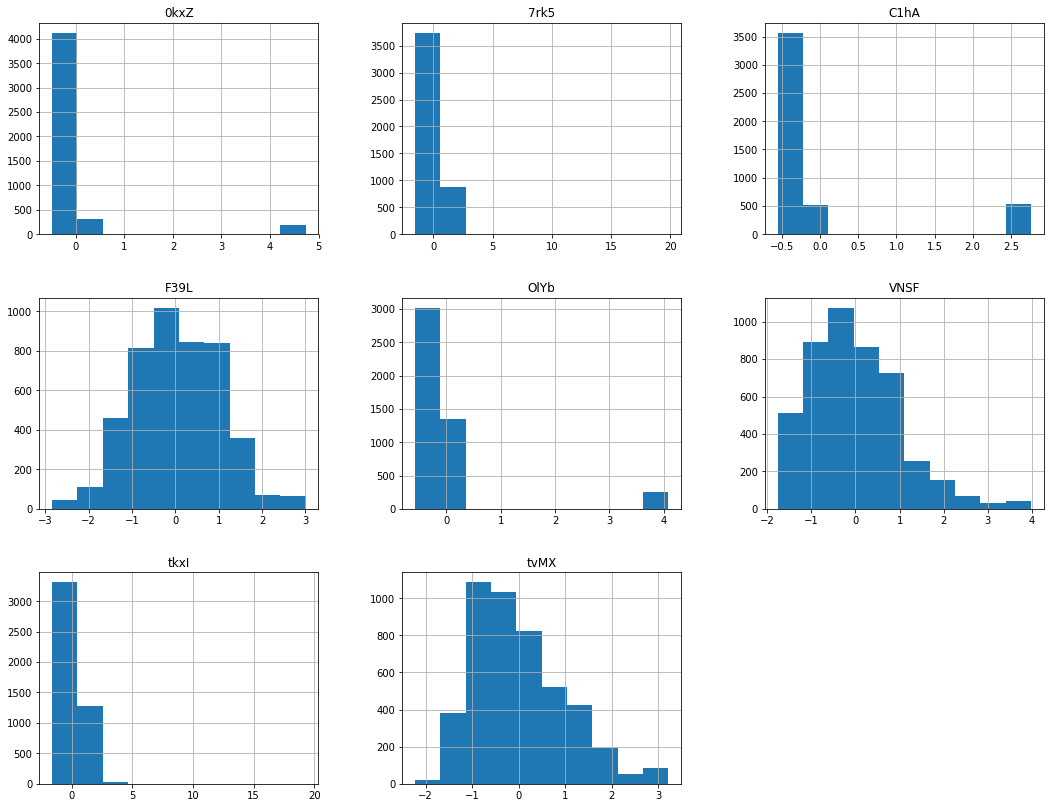

In [4]:
import matplotlib.pyplot as plt
x_train.hist(figsize=(18, 14))
plt.show()

##### Relación feature - feature

Siempre es buena idea explorar la correlación de las variables aún si no se planea eliminarlas.

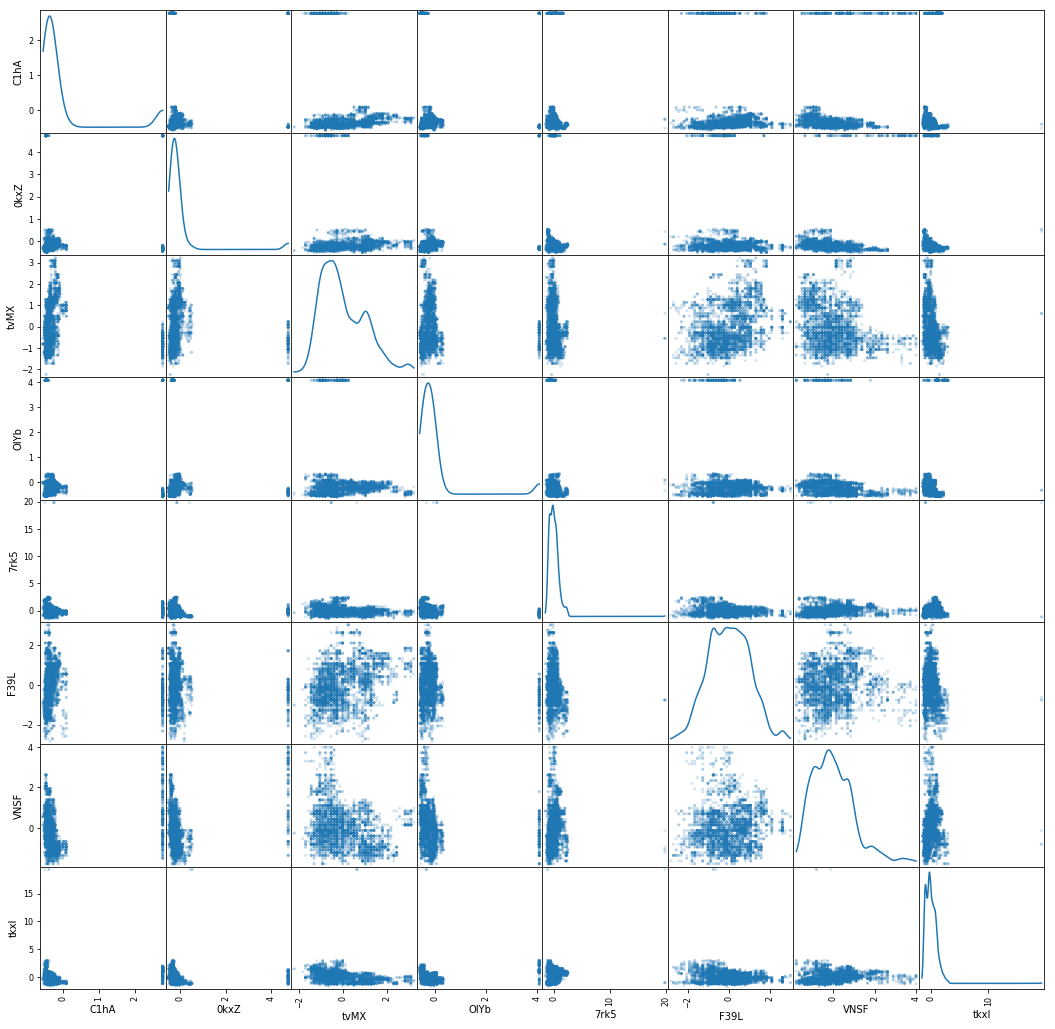

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(x_train, alpha=0.2, figsize=(18, 18), diagonal='kde')
plt.show()

Como se puede observar, no existen variables correlacionadas entre sí.

# Esquema de entrenamiento

Según las conclusiones obtenidas de las preguntas anteriores, se ha decidido que el mejor esquema corresponde a uno con dos capas escondidas con un número de neuronas decreciente en potencias de 2, utilizando como función de activación **ReLU** y con el optimizador **RMSProp**. La función de perdida utilizada corresponde a **categorical_crossentropy** debido a que el problema es de clasificación.

Por último, se define un entrenamiento con 300 epochs, con un learning reate de $0.001$ sintonizado de forma empírica, y con un leve decay para evitar obtener $NaN$.

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop

def define_neural_network():
    model = Sequential()
    
    # Input
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='uniform'))
    model.add(Activation("relu"))
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(Activation("relu"))
    model.add(Dense(24, kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))
    sgd = RMSprop(lr=0.001, decay=0.005)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=["acc"])
    return model
    
    
define_neural_network().summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               2304      
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                3096      
_________________________________________________________________
activation_12 (Activation)   (None, 24)                0         
Total params: 38,296
Trainable params: 38,296
Non-trainable params: 0
_________________________________________________________________


In [13]:
model = define_neural_network()
history = model.fit(x_train, y_train, epochs=300,
        verbose=1, validation_data=(x_test, y_test))

Train on 4620 samples, validate on 1980 samples
Epoch 1/300
4620/4620 [==============================] - 1s 156us/step - loss: 2.0858 - acc: 0.3775 - val_loss: 1.3400 - val_acc: 0.5202
Epoch 2/300
4620/4620 [==============================] - 0s 69us/step - loss: 1.1672 - acc: 0.6158 - val_loss: 1.0235 - val_acc: 0.6682
Epoch 3/300
4620/4620 [==============================] - 0s 72us/step - loss: 0.9577 - acc: 0.6898 - val_loss: 0.8923 - val_acc: 0.7222
Epoch 4/300
4620/4620 [==============================] - 0s 75us/step - loss: 0.8545 - acc: 0.7277 - val_loss: 0.8226 - val_acc: 0.7495
Epoch 5/300
4620/4620 [==============================] - 0s 61us/step - loss: 0.7920 - acc: 0.7543 - val_loss: 0.7814 - val_acc: 0.7586
Epoch 6/300
4620/4620 [==============================] - 0s 64us/step - loss: 0.7524 - acc: 0.7630 - val_loss: 0.7436 - val_acc: 0.7677
Epoch 7/300
4620/4620 [==============================] - 0s 61us/step - loss: 0.7207 - acc: 0.7712 - val_loss: 0.7194 - val_acc: 0.7808

4620/4620 [==============================] - 0s 57us/step - loss: 0.4856 - acc: 0.8517 - val_loss: 0.5180 - val_acc: 0.8323
Epoch 61/300
4620/4620 [==============================] - 0s 57us/step - loss: 0.4843 - acc: 0.8498 - val_loss: 0.5168 - val_acc: 0.8308
Epoch 62/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4832 - acc: 0.8530 - val_loss: 0.5157 - val_acc: 0.8318
Epoch 63/300
4620/4620 [==============================] - 0s 60us/step - loss: 0.4821 - acc: 0.8517 - val_loss: 0.5148 - val_acc: 0.8318
Epoch 64/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4812 - acc: 0.8522 - val_loss: 0.5146 - val_acc: 0.8303
Epoch 65/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4800 - acc: 0.8539 - val_loss: 0.5139 - val_acc: 0.8348
Epoch 66/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4791 - acc: 0.8537 - val_loss: 0.5121 - val_acc: 0.8308
Epoch 67/300
4620/4620 [==============================

Epoch 120/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4430 - acc: 0.8647 - val_loss: 0.4816 - val_acc: 0.8429
Epoch 121/300
4620/4620 [==============================] - 0s 57us/step - loss: 0.4426 - acc: 0.8652 - val_loss: 0.4812 - val_acc: 0.8439
Epoch 122/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4422 - acc: 0.8649 - val_loss: 0.4807 - val_acc: 0.8449
Epoch 123/300
4620/4620 [==============================] - 0s 59us/step - loss: 0.4417 - acc: 0.8639 - val_loss: 0.4803 - val_acc: 0.8455
Epoch 124/300
4620/4620 [==============================] - 0s 59us/step - loss: 0.4413 - acc: 0.8658 - val_loss: 0.4799 - val_acc: 0.8439
Epoch 125/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4408 - acc: 0.8647 - val_loss: 0.4798 - val_acc: 0.8449
Epoch 126/300
4620/4620 [==============================] - 0s 57us/step - loss: 0.4405 - acc: 0.8656 - val_loss: 0.4790 - val_acc: 0.8455
Epoch 127/300
4620/4620 [=========

4620/4620 [==============================] - 0s 59us/step - loss: 0.4224 - acc: 0.8714 - val_loss: 0.4631 - val_acc: 0.8505
Epoch 180/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4221 - acc: 0.8729 - val_loss: 0.4628 - val_acc: 0.8510
Epoch 181/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4219 - acc: 0.8710 - val_loss: 0.4627 - val_acc: 0.8505
Epoch 182/300
4620/4620 [==============================] - 0s 59us/step - loss: 0.4215 - acc: 0.8719 - val_loss: 0.4626 - val_acc: 0.8510
Epoch 183/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4212 - acc: 0.8721 - val_loss: 0.4626 - val_acc: 0.8500
Epoch 184/300
4620/4620 [==============================] - 0s 59us/step - loss: 0.4211 - acc: 0.8710 - val_loss: 0.4621 - val_acc: 0.8515
Epoch 185/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.4208 - acc: 0.8721 - val_loss: 0.4619 - val_acc: 0.8515
Epoch 186/300
4620/4620 [=======================

4620/4620 [==============================] - 0s 62us/step - loss: 0.4088 - acc: 0.8764 - val_loss: 0.4512 - val_acc: 0.8556
Epoch 239/300
4620/4620 [==============================] - 0s 66us/step - loss: 0.4086 - acc: 0.8766 - val_loss: 0.4510 - val_acc: 0.8551
Epoch 240/300
4620/4620 [==============================] - 0s 63us/step - loss: 0.4084 - acc: 0.8758 - val_loss: 0.4509 - val_acc: 0.8551
Epoch 241/300
4620/4620 [==============================] - 0s 62us/step - loss: 0.4082 - acc: 0.8771 - val_loss: 0.4506 - val_acc: 0.8551
Epoch 242/300
4620/4620 [==============================] - 0s 62us/step - loss: 0.4081 - acc: 0.8764 - val_loss: 0.4503 - val_acc: 0.8556
Epoch 243/300
4620/4620 [==============================] - 0s 61us/step - loss: 0.4078 - acc: 0.8766 - val_loss: 0.4502 - val_acc: 0.8556
Epoch 244/300
4620/4620 [==============================] - 0s 60us/step - loss: 0.4077 - acc: 0.8768 - val_loss: 0.4501 - val_acc: 0.8556
Epoch 245/300
4620/4620 [=======================

4620/4620 [==============================] - 0s 59us/step - loss: 0.3989 - acc: 0.8801 - val_loss: 0.4419 - val_acc: 0.8586
Epoch 298/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.3987 - acc: 0.8799 - val_loss: 0.4419 - val_acc: 0.8586
Epoch 299/300
4620/4620 [==============================] - 0s 58us/step - loss: 0.3985 - acc: 0.8803 - val_loss: 0.4416 - val_acc: 0.8576
Epoch 300/300
4620/4620 [==============================] - 0s 59us/step - loss: 0.3984 - acc: 0.8801 - val_loss: 0.4415 - val_acc: 0.8576


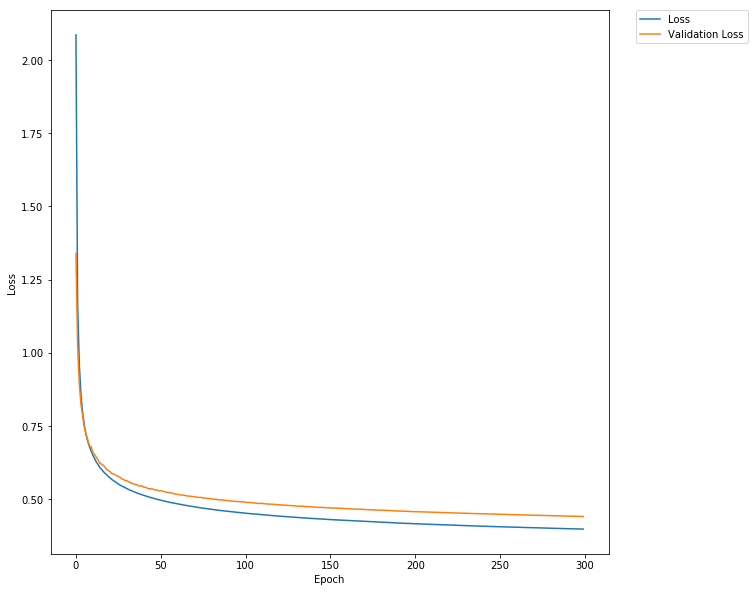

In [14]:
import matplotlib.pyplot as plt
loss_y = history.history['loss']
loss_x = range(0, 300)

val_loss_y = history.history['val_loss']


# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, loss_y, label="Loss")
plt.plot(loss_x, val_loss_y, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

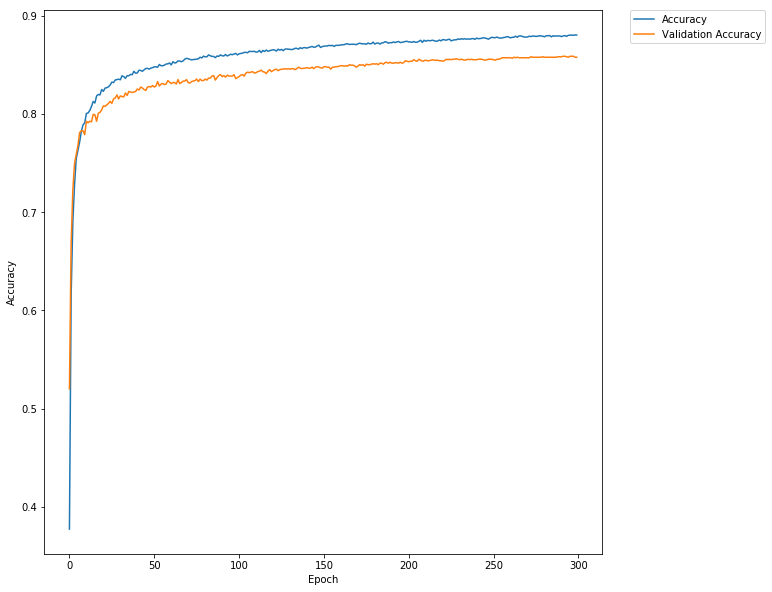

In [15]:
import matplotlib.pyplot as plt
acc_y = history.history['acc']
acc_x = range(0, 300)

val_acc_y = history.history['val_acc']


# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(acc_x, acc_y, label="Accuracy")
plt.plot(acc_x, val_acc_y, label="Validation Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.show()

In [16]:
print(history.history["val_acc"][len(history.history["val_acc"]) - 1])

0.8575757572145173


El error obtenido con el esquema propuesto corresponde a $85.75\%$, lo cual es mejor que $75\%$.